In [1]:
from torch import device, nn, cuda, load
from torchvision import transforms
from torchvision.models import resnet34
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def CustomResNetPredict(image_path, model_loc='ResNet34_parameters.pth', hardware=None):

    #Load the model architecture without pretrained values.
    model = resnet34(pretrained=False)

    #Change the last layer structure to match with the customisation ResNet architecture.
    model.fc = nn.Linear(512, 3)

    #Set gradients of all parameters to False, it is not required to calculate gradients in evaluation stage.
    for parameter in model.parameters():
        parameter.required_grad = False

    #Check for available hardware device if not prescribed any.
    if not hardware:
        hardware = device("cuda" if cuda.is_available() else "cpu")

    #Move the model onto available hardware
    model = model.to(hardware)

    #Load the trained model parameters on to the availale hardware
    state = load(model_loc, hardware)

    #Copy the trained model parameters into the model architecture
    model.load_state_dict(state_dict=state, strict=False)

    #Set the model to evaluatin mode. This step is important for using the model to perform predictions.
    model.eval()

    #Transform the image to required size and convert to a tensor.
    imsize = 224
    crop_area = (0,0,5184,2700)
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

    def image_loader(image_path):
        image = Image.open(image_path)
        #image = image.crop(crop_area)
        image = loader(image).float()
        #Unsqueeze will add a dimention to the image tensor, the extra dimention will refer to batch size
        image = image.unsqueeze(0) 
        return image

    image = image_loader(image_path)
    #Move the image onto the available hardware device.
    image = image.to(hardware)
    predict = model(image)
    return predict

In [3]:
classes = ['Clear Sky', 'Cloudy', 'Partly Cloudy']

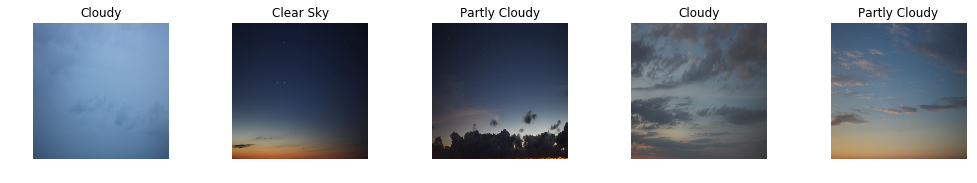

In [4]:
images = ['4942.jpg','3953.jpg','106.jpg','10301.jpg','460.jpg']
labels = ['Cloudy','Clear Sky','Partly Cloudy','Cloudy','Partly Cloudy']

fig, ax = plt.subplots(nrows=1, ncols=len(images),sharey=True)
for index, image in enumerate(images):
    ax[index].imshow(plt.imread(image))
    ax[index].set_title(labels[index])
    ax[index].axis('off')
plt.tight_layout()
fig.set_size_inches(15,15)
plt.show()

In [5]:
for image in images:
    predict = CustomResNetPredict(image_path=image,hardware='cpu')
    print(f'Predictions: {predict}')
    print(f'Predicted Class: {classes[predict.argmax()]}')
    print('--'*50)

Predictions: tensor([[ 0.5570,  2.2444, -4.1714]], grad_fn=<ThAddmmBackward>)
Predicted Class: Cloudy
----------------------------------------------------------------------------------------------------
Predictions: tensor([[ 3.0361,  0.1053, -3.9715]], grad_fn=<ThAddmmBackward>)
Predicted Class: Clear Sky
----------------------------------------------------------------------------------------------------
Predictions: tensor([[-1.9222, -1.5620,  3.2027]], grad_fn=<ThAddmmBackward>)
Predicted Class: Partly Cloudy
----------------------------------------------------------------------------------------------------
Predictions: tensor([[-2.6025,  2.3551, -0.3417]], grad_fn=<ThAddmmBackward>)
Predicted Class: Cloudy
----------------------------------------------------------------------------------------------------
Predictions: tensor([[ 0.0692, -1.0717,  0.7087]], grad_fn=<ThAddmmBackward>)
Predicted Class: Partly Cloudy
---------------------------------------------------------------------